In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from bbl_utils import *
from xmitgcm import open_mdsdataset 
from xhistogram.xarray import histogram

In [3]:
Γ = 0.0008613659531090722
θ = 1.53E-3
f = -0.53e-4

In [4]:
dx = 500.
delta_t = 60.
diter = 28800

iter0 = 3182400
Niter = 22
dt = 1728000

iters = np.arange(iter0, iter0 + diter*Niter, diter)

In [5]:
data_dir = f"../../MITgcm/experiments/rotated_BBTRE_rest-tracer/run/"
ds = open_mdsdataset(data_dir,iters=iters,ignore_unknown_vars=True,prefix=["budgetDiag", "tracer01Diag", "tracer02Diag"], delta_t=60.)

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/xmitgcm/mds_store.py:175: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':


In [6]:
extend_multiples = [-1, 0]
xslice = [-3e5,3e5]

Lx = ds['XC'].size*dx
ds = periodic_extend(ds, ['XC', 'XG'], Lx, extend_multiples)
ds = ds.sel(XC=slice(*xslice), XG=slice(*xslice))
H = ds['Depth'].max().values.copy().astype('>f8')
ds, grid = preprocess(ds, θ)
ds['dV'] = (ds.drF * ds.rA * ds.hFacC)

In [7]:
ds = ds.chunk({'XC': 400, 'XG': 400})

In [8]:
ds['THETA'] = ds['THETA'].where(ds['THETA'] != 0.)
ds['THETA_BG_C'] = Γ*ds['Zr']
ds['THETA_BG_U'] = Γ*ds['Zr_U']
ds['THETA_BG_V'] = Γ*ds['Zr_V']
ds['THETA_BG_W'] = Γ*ds['Zr_W']
ds['θ'] = ds['THETA'] + ds['THETA_BG_C']

In [9]:
mask1 = ~((((ds['θ'] <= 1.25) & (ds['XC'] <= -100e3)) | ((ds['θ'] >= 1.65) & (ds['XC'] >= 100e3))).isel(time=-1))
ds['TRAC01'] = ds['TRAC01'].where(mask1, 1.e-40)

mask2 = ~((((ds['θ'] <= 1.25) & (ds['XC'] <= -90e3)) | ((ds['θ'] >1.75))).isel(time=-1))
ds['TRAC02'] = ds['TRAC02'].where(mask2, 1.e-40)

In [10]:
TRAC01_xy = (ds['TRAC01']*ds['drF']).sum(dim='Z').isel(time=[-1]).compute()
TRAC01_xy /= TRAC01_xy.max(dim=['XC', 'YC'])

TRAC01_xz = (ds['TRAC01']*ds['rA']).sum(dim='YC').isel(time=[-1]).compute()
TRAC01_xz /= TRAC01_xz.max(dim=['XC', 'Z'])

TRAC02_xy = (ds['TRAC02']*ds['drF']).sum(dim='Z').isel(time=[-1]).compute()
TRAC02_xy /= TRAC02_xy.max(dim=['XC', 'YC'])

TRAC02_xz = (ds['TRAC02']*ds['rA']).sum(dim='YC').isel(time=[-1]).compute()
TRAC02_xz /= TRAC02_xz.max(dim=['XC', 'Z'])


/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater_equal
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less_equal
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater_equal
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less_equal
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less_equal
  return func(*(_execute_task(a, cache) for a in a

In [11]:
for i in [1,2]:
    ds[f'M_Tr0{i}'] = (ds[f'TRAC0{i}']*ds['dV']).sum(dim=['Z', 'YC', 'XC']).compute()
    ds[f'Xbar_Tr0{i}'] = ((ds['XC']*ds[f'TRAC0{i}']*ds['dV']).sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{i}']).compute()
    ds[f'Ybar_Tr0{i}'] = ((ds['YC']*ds[f'TRAC0{i}']*ds['dV']).sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{i}']).compute()
    ds[f'Zbar_Tr0{i}'] = ((ds['Z']*ds[f'TRAC0{i}']*ds['dV']).sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{i}']).compute()
    ds[f'θbar_Tr0{i}'] = ((ds['θ']*ds[f'TRAC0{i}']*ds['dV']).sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{i}']).compute()

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater_equal
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less_equal
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater_equal
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less_equal
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater_equal
  return func(*(_execute_task(a, cache) for a i

In [12]:
δz = 40.
δx = 0.5e4
δy = 0.5e4
x1 = 3.e4; x2 = x1;
y1 = 3.e4; y2 = y1;

z1 = (H - ds['Depth'].sel(XC = x1, YC = y1, method='nearest') + 900.).values
z2 = (H - ds['Depth'].sel(XC = x2, YC = y2, method='nearest') + 150).values

C1 = np.exp(- ((ds['XC'] - x1)/δx)**2 - ((ds['YC'] - y1)/δx)**2 - ((ds['Z'] - z1)/δz)**2)
C1 = C1.assign_coords({'Xr': ds['Xr'], 'Zr': ds['Zr']})
C1xy = (C1*ds['drF']).sum(dim='Z')
C1xy = C1xy/C1xy.max()
C1xz = (C1*ds['rA']).sum(dim='YC')
C1xz = C1xz/C1xz.max()

C2 = np.exp(- ((ds['XC'] - x2)/δx)**2 - ((ds['YC'] - y2)/δx)**2 - ((ds['Z'] - z2)/δz)**2)
C2 = C2.assign_coords({'Xr': ds['Xr'], 'Zr': ds['Zr']})
C2xy = (C2*ds['drF']).sum(dim='Z')
C2xy = C2xy/C2xy.max()
C2xz = (C2*ds['rA']).sum(dim='YC')
C2xz = C2xz/C2xz.max()

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater_equal
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less_equal
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater_equal
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less_equal
  return func(*(_execute_task(a, cache) for a in args))
/home/h

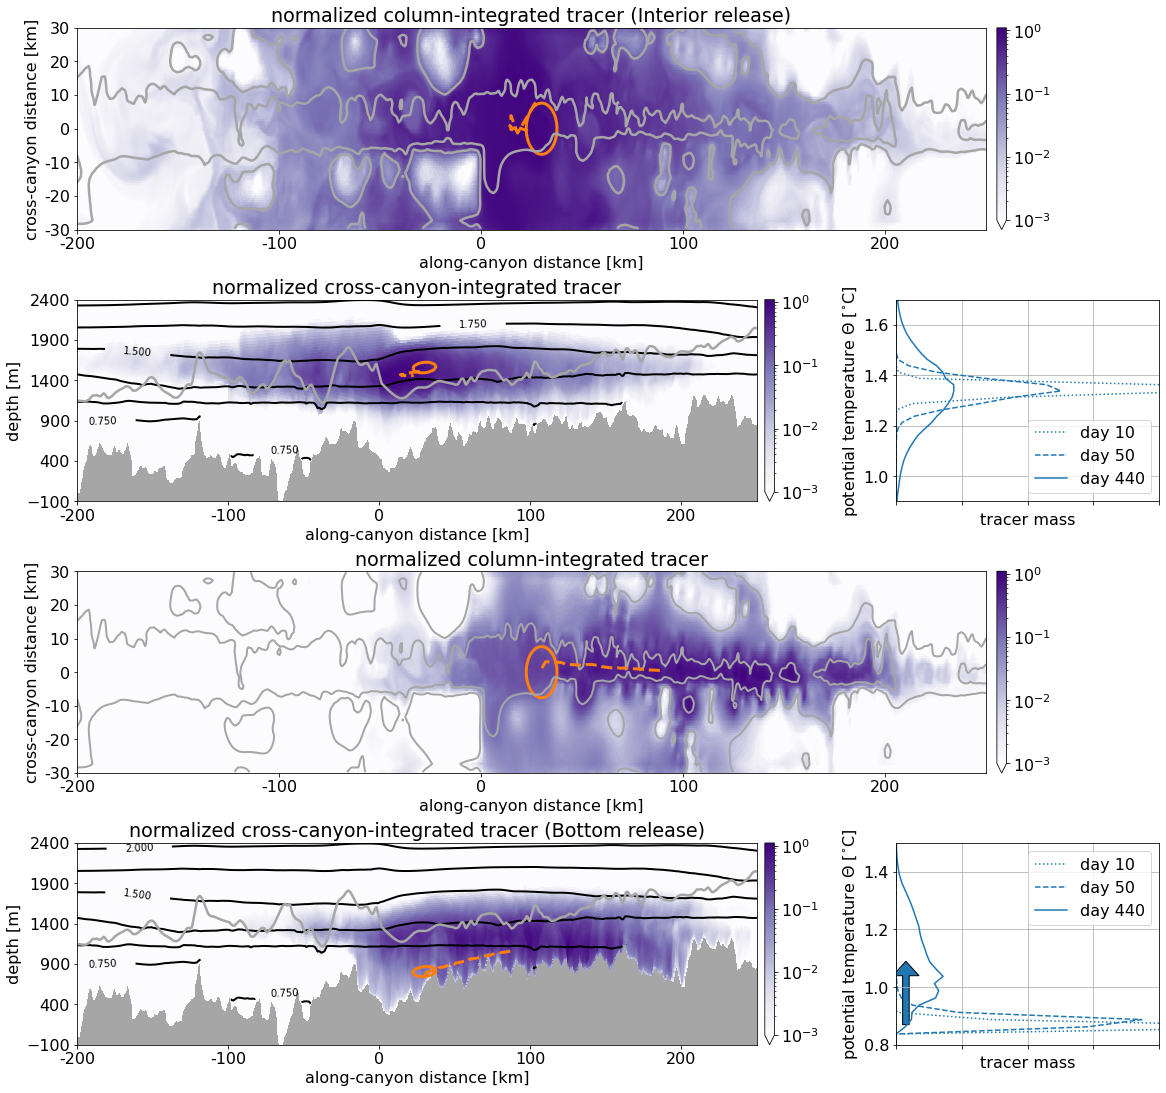

In [13]:
θlevels = np.arange(0.5, 2.5, 0.025)

ti = -1
xlims = [-2e5,2.5e5]
ylims1 = [500,2500]
ylims2 = [0,2250]

θlw = 2.
blw = 2.5
tlw = 3.0

linestyle = [":", "--", "-"]
tis = [0, 2, -1]
labels = [10, 50, 440]

ylim = [[0.9, 1.7], [0.8, 1.5]]

fig = plt.figure(figsize=(16,15))#, constrained_layout=True)
gs = fig.add_gridspec(4, 4)

f_ax1 = fig.add_subplot(gs[0, :])
tmap = plt.get_cmap("Purples")
tcolor = "C1"
θcolor = "k"
vmax = 1.1

q = TRAC01_xy.isel(time=ti).plot(x='XC', y='YC', norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=vmax), cmap=tmap)
q.colorbar.remove()
plt.colorbar(q, pad=0.01, extend='min', label="")
C1xy.plot.contour(x='XC', y='YC', levels=[0.1], colors=tcolor, linewidths=tlw)
plt.plot(ds['Xbar_Tr01'], ds['Ybar_Tr01'], "--", color=tcolor, lw=tlw)
(H-ds['Depthr']).plot.contour(colors=(nancol,), linewidths = blw, levels=[1000, 1500])
plt.xlim(xlims)
plt.title("normalized column-integrated tracer (Interior release)")
plt.xticks(np.arange(-2e5, 3e5, 1e5), np.arange(-200, 300, 100))
plt.xlabel("along-canyon distance [km]")
plt.yticks(np.arange(0, 7e4, 1e4), np.arange(-30, 40, 10))
plt.ylabel("cross-canyon distance [km]")

f_ax2 = fig.add_subplot(gs[1, :-1], facecolor=nancol)
q = TRAC01_xz.isel(time=ti).plot(x='Xr', y='Zr', norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=vmax), cmap=tmap)
q.colorbar.remove()
plt.colorbar(q, pad=0.01, extend='min', label="")
plt.plot(ds['Xbar_Tr01'], ds['Zbar_Tr01'], "--", color=tcolor, lw=tlw)
(H-ds['Depthr']).isel(YC=np.append(np.arange(-15,0), np.arange(0,15))).mean(dim='YC').plot(color=nancol, lw=blw)
C1xz.plot.contour(x='Xr', y='Zr', levels=[0.1], colors=tcolor, linewidths=tlw)
CS = ds['θ'].mean(dim='YC').isel(time=0).plot.contour(x='Xr', y='Zr', colors="k", levels=np.arange(0.5,2.5,0.25), linewidths=θlw)
f_ax2.clabel(CS, inline=1, fontsize=10)
plt.title("")
plt.xlim(xlims)
plt.ylim(ylims2)
plt.title("normalized cross-canyon-integrated tracer")
plt.xticks(np.arange(-2e5, 3e5, 1e5), np.arange(-200, 300, 100))
plt.xlabel("along-canyon distance [km]")
plt.yticks(np.arange(-100, 2500, 500))
plt.ylabel("depth [m]")

f_ax3 = fig.add_subplot(gs[1, -1])
for i, ti in enumerate(tis):
    h = histogram(ds['θ'].isel(time=ti), bins=[θlevels], weights=(ds[f'TRAC01']*ds['dV']).isel(time=ti))
    h.plot(y = "θ_bin", color="C0", linestyle=linestyle[i], label=f"day {labels[i]}")
    plt.ylim(ylim[0])
    plt.ylabel(r"potential temperature $\Theta$ [$^{\circ}$C]")
    plt.xlabel("tracer mass")
    plt.xlim([0,2e9])
    plt.xticks(labels=None)
plt.legend()

f_ax3.get_xaxis().set_ticklabels([])
plt.grid(True)
# width = 0.05e9; head_width = 0.2e9; head_length = 0.05;
# plt.arrow(
#     width*1.5, ds['θbar'].isel(time=0).values, 0, (ds['θbar'].isel(time=-1) - ds['θbar'].isel(time=0)).values,
#     width=width, head_width=head_width, head_length=head_length, length_includes_head = True
# )

f_ax4 = fig.add_subplot(gs[2, :])
q = TRAC02_xy.isel(time=ti).plot(x='XC', y='YC', norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=vmax), cmap=tmap)
q.colorbar.remove()
plt.colorbar(q, pad=0.01, extend='min', label="")
plt.plot(ds['Xbar_Tr02'], ds['Ybar_Tr02'], "--", color=tcolor, lw=tlw)
C2xy.plot.contour(x='XC', y='YC', levels=[0.1], colors=tcolor, linewidths=tlw)
(H-ds['Depthr']).plot.contour(colors=(nancol,), linewidths = 2., levels=[1000, 1500])
plt.xlim(xlims)
plt.title("normalized column-integrated tracer")
plt.xticks(np.arange(-2e5, 3e5, 1e5), np.arange(-200, 300, 100))
plt.xlabel("along-canyon distance [km]")
plt.yticks(np.arange(0, 7e4, 1e4), np.arange(-30, 40, 10))
plt.ylabel("cross-canyon distance [km]")

f_ax5 = fig.add_subplot(gs[3, :-1], facecolor=nancol)
q = TRAC02_xz.isel(time=ti).plot(x='Xr', y='Zr', norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=vmax), cmap=tmap)
q.colorbar.remove()
plt.colorbar(q, pad=0.01, extend='min', label="")
(H-ds['Depthr']).isel(YC=np.append(np.arange(-15,0), np.arange(0,15))).mean(dim='YC').plot(color=nancol, lw=blw)
plt.ylim(0, 2500)
plt.plot(ds['Xbar_Tr02'], ds['Zbar_Tr02'], "--", color=tcolor, lw=tlw)
C2xz.plot.contour(x='Xr', y='Zr', levels=[0.1], colors=tcolor, linewidths=tlw)
CS = ds['θ'].mean(dim='YC').isel(time=0).plot.contour(x='Xr', y='Zr', colors="k", levels=np.arange(0.5,2.5,0.25), linewidths=θlw)
f_ax5.clabel(CS, inline=1, fontsize=10)
plt.title("")
plt.xlim(xlims)
plt.ylim(ylims2)
plt.title("normalized cross-canyon-integrated tracer (Bottom release)")
plt.xticks(np.arange(-2e5, 3e5, 1e5), np.arange(-200, 300, 100))
plt.xlabel("along-canyon distance [km]")
plt.yticks(np.arange(-100, 2500, 500))
plt.ylabel("depth [m]")

f_ax6 = fig.add_subplot(gs[3, -1])
for i, ti in enumerate(tis):
    h = histogram(ds['θ'].isel(time=ti), bins=[θlevels], weights=(ds[f'TRAC02']*ds['dV']).isel(time=ti))
    h.plot(y = "θ_bin", color="C0", linestyle=linestyle[i], label=f"day {labels[i]}")
    plt.ylim(ylim[1])
    plt.ylabel(r"potential temperature $\Theta$ [$^{\circ}$C]")
    plt.xlabel("tracer mass")
    plt.xlim([0,2e9])
    plt.xticks(labels=None)
plt.legend()
f_ax6.get_xaxis().set_ticklabels([])
plt.grid(True)
width = 0.05e9; head_width = 0.2e9; head_length = 0.05;
plt.arrow(
    width*1.5, ds['θbar_Tr02'].isel(time=0).values, 0, (ds['θbar_Tr02'].isel(time=-1) - ds['θbar_Tr02'].isel(time=0)).values,
    width=width, head_width=head_width, head_length=head_length, length_includes_head = True
)

plt.tight_layout(pad=0, h_pad=0.1)
plt.savefig("../../figures/BBTRE/tracer_spreading_440_days.png", dpi=100, bbox_inches="tight")

## Tracer-budgets

In [14]:
for tr, tr_name in enumerate(["_TH", "Tr01", "Tr02"]):
    tmp = tracer_flux_budget(ds, grid, tr_name, θ=θ, Γ=Γ).chunk({'Z': -1, 'YC': -1, 'XC': 400})
    if tr_name[0] != "_":
        tr_name = "_"+tr_name
    tmp[f'total_tendency{tr_name}'] = tmp[f'conv_total_flux{tr_name}'].fillna(0.)
    tmp[f'total_tendency_truth{tr_name}'] = ds.TOTTTEND * ds['dV'] * day2seconds
    tmp[f'diff_tendency{tr_name}'] = tmp[f'conv_horiz_diff_flux{tr_name}'] + tmp[f'conv_vert_diff_flux{tr_name}']
    tmp[f'adv_tendency{tr_name}'] = tmp[f'conv_horiz_adv_flux{tr_name}'] + tmp[f'conv_vert_adv_flux{tr_name}']
    if tr_name == "_TH":
        tmp[f'adv_tendency{tr_name}'] = tmp[f'adv_tendency{tr_name}'] + tmp['conv_adv_flux_anom_TH']
        tmp[f'diff_tendency{tr_name}'] = tmp[f'diff_tendency{tr_name}'] + tmp['conv_vert_diff_flux_anom_TH']
        
    ds = xr.merge([ds, tmp])

In [15]:
for tr, tr_mask in enumerate([mask1, mask2], start=1):
    for dv in ds.data_vars:
        if ((f"_Tr0{tr}" in dv) | (f'Tp_gTr0{tr}' in dv)) & (len(ds[dv].dims) >= 3.):
            print(f"Masking {dv}", end="\n")
            ds[dv] = ds[dv].where(tr_mask, 0.)

Masking Tp_gTr01
Masking conv_horiz_adv_flux_Tr01
Masking conv_horiz_diff_flux_Tr01
Masking conv_vert_adv_flux_Tr01
Masking conv_vert_diff_flux_Tr01
Masking conv_total_flux_Tr01
Masking total_tendency_Tr01
Masking total_tendency_truth_Tr01
Masking diff_tendency_Tr01
Masking adv_tendency_Tr01
Masking Tp_gTr02
Masking conv_horiz_adv_flux_Tr02
Masking conv_horiz_diff_flux_Tr02
Masking conv_vert_adv_flux_Tr02
Masking conv_vert_diff_flux_Tr02
Masking conv_total_flux_Tr02
Masking total_tendency_Tr02
Masking total_tendency_truth_Tr02
Masking diff_tendency_Tr02
Masking adv_tendency_Tr02


## Tracer-weighted temperature (first moment)

The rate of change of the first temperature moment $\overline{\Theta} = \dfrac{\int \Theta c \,\text{d}V}{\int c \; \text{d}V}$ (average temperature of the tracer distribution) is given by

\begin{equation}
\int \partial_{t}  \left( \Theta c \right) \text{d}V + \int \left( c \nabla \cdot \mathbf{u} \Theta + \Theta \nabla \cdot \mathbf{u} c \right) \text{d}V = \int \left( c \nabla \cdot \mathbf{F_{\Theta}} + \Theta \nabla \cdot \mathbf{F_{c}} \right) \text{d}V,
\end{equation}
after dividing by the total tracer mass $M = \int c \; \text{d}V$.
 
In practice, we use the follow , where each term can be diagnosed from an instantaneous snapshot of the solution at machine precision and we can compare the LHS to the RHS to ensure our budget is closed. In practice, hyperdiffusion has a small but non-zero effect on the buoyancy budget and since it is omitted here, it introduces small errors in the budget.

\begin{equation}
\int  \left( \Theta \partial_{t} c + c\partial_{t} \Theta \right) \text{d}V + \int \left( c \nabla \cdot \mathbf{u} \Theta + \Theta \nabla \cdot \mathbf{u} c \right) \text{d}V = \int \left( c \nabla \cdot \mathbf{F_{\Theta}} + \Theta \nabla \cdot \mathbf{F_{c}} \right) \text{d}V
\end{equation}

In practice, we decompose $\Theta = \overline{\Theta} + \Theta'$ where $\partial_{z} \overline{\Theta} = \Gamma$ is a constant lapse rate.

\begin{equation}
\int \left( \left( \overline{\Theta} + \Theta' \right) \partial_{t} c + c \partial_{t} \Theta' \right) \text{d}V +
\int \left( c \nabla \cdot \mathbf{u} \Theta' + cw \Gamma + (\overline{\Theta} + \Theta') \nabla \cdot \mathbf{u} c \right) \text{d}V =
\int \left( c \nabla \cdot \mathbf{F_{\Theta'}} - c \partial_{z} ( \kappa \Gamma) + (\overline{\Theta} + \Theta') \nabla \cdot \mathbf{F_{c}} \right) \text{d}V
\end{equation}

By applying no-flux and no-flow boundary conditions, this equation can be re-written in terms of the temperature velocity $\omega = \nabla \cdot \left( \kappa \nabla \Theta \right)$,
\begin{equation}
\partial_{t} \overline{\Theta} = 2 \overline{\omega}
\end{equation}

In [16]:
tr = 1

In [17]:
ds[f'ωbar_Tr0{tr}'] = ((ds['diff_tendency_TH'] * ds[f'TRAC0{tr}']).sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute()
ds[f'2ω_Tr0{tr}'] = 2*ds[f'ωbar_Tr0{tr}']

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater_equal
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less_equal
  return func(*(_execute_task(a, cache) for a in args))


In [18]:
ds[f'θ_dcdt_Tr0{tr}'] = ds['θ'] * ds[f'Tp_gTr0{tr}'] * ds['dV']
ds[f'c_dθdt_Tr0{tr}'] = ds[f'TRAC0{tr}'] * (ds['TOTTTEND']* day2seconds) * ds['dV']

ds[f'd(θbar)dt_Tr0{tr}'] = (
    (ds[f'θ_dcdt_Tr0{tr}'].sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute() +
    (ds[f'c_dθdt_Tr0{tr}'].sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute()
)

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater_equal
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less_equal
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater_equal
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less_equal
  return func(*(_execute_task(a, cache) for a in args))


In [19]:
ds[f'c_div_uθ_Tr0{tr}'] = ds[f'TRAC0{tr}']*ds['adv_tendency_TH']
ds[f'θ_div_uc_Tr0{tr}'] = ds['θ']*ds[f'adv_tendency_Tr0{tr}']

ds[f'c_div_Fθ_Tr0{tr}'] = ds[f'TRAC0{tr}']*ds['diff_tendency_TH']
ds[f'θ_div_Fc_Tr0{tr}'] = ds['θ']*ds[f'diff_tendency_Tr0{tr}']

In [20]:
ds[f'd(θbar)dt_DIFF_Tr0{tr}'] = (
    (ds[f'θ_div_Fc_Tr0{tr}'].sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute() + 
    (ds[f'c_div_Fθ_Tr0{tr}'].sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute()
)

ds[f'd(θbar)dt_ADV_Tr0{tr}'] = (
    (ds[f'θ_div_uc_Tr0{tr}'].sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute() +
    (ds[f'c_div_uθ_Tr0{tr}'].sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute()
)

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater_equal
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less_equal
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater_equal
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less_equal
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater_equal
  return func(*(_execute_task(a, cache) for a i

In [21]:
ds[f'd(θbar)dt_RHS_Tr0{tr}'] = ds[f'd(θbar)dt_DIFF_Tr0{tr}'] + ds[f'd(θbar)dt_ADV_Tr0{tr}']

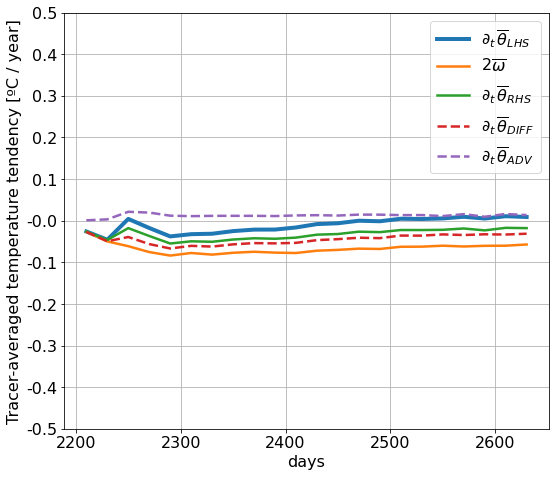

In [22]:
ds['days'] = ds['time'].astype("float64")*(1.e-9)/86400.
ds = ds.assign_coords({'days': ds['days']})

plt.figure(figsize=(8,7))
ds[f'd(θbar)dt_Tr0{tr}'].plot(x='days', lw=4, label=r"$\partial_{t}\, \overline{\theta}_{LHS}$")
ds[f'2ω_Tr0{tr}'].plot(x='days', lw=2.5, linestyle="-", label=r"$2 \overline{\omega}$")
ds[f'd(θbar)dt_RHS_Tr0{tr}'].plot(x='days', lw=2.5, linestyle="-", label=r"$\partial_{t}\, \overline{\theta}_{RHS}$")
ds[f'd(θbar)dt_DIFF_Tr0{tr}'].plot(x='days', lw=2.5, linestyle="--", label=r"$\partial_{t}\, \overline{\theta}_{DIFF}$")
ds[f'd(θbar)dt_ADV_Tr0{tr}'].plot(x='days', lw=2.5, linestyle="--", label=r"$\partial_{t}\, \overline{\theta}_{ADV}$")
plt.legend()
plt.ylabel("Tracer-averaged temperature tendency [ºC / year]")
levs = np.arange(-0.5, 0.6, 0.1)
plt.yticks(levs/(86400*365), np.round(levs,2))
plt.grid(True)

plt.tight_layout()

plt.savefig(f"../../figures/BBTRE/first_temperature_moment_Tr0{tr}.png", dpi=100, bbox_inches="tight")

## Tracer-weighted temperature variance (centered second moment)

The rate of change of the second temperature moment $\overline{\Theta^{2}} = \dfrac{\int \Theta^{2} c \,\text{d}V}{\int c \; \text{d}V}$ (average temperature variance of the tracer distribution) is given by

\begin{equation}
\int \partial_{t}  \left( \Theta^{2} c \right) \text{d}V + \int \left( c \nabla \cdot \mathbf{u} \Theta^{2} + \Theta^{2} \nabla \cdot \mathbf{u} c \right) \text{d}V = \int \left( c \nabla \cdot \mathbf{F_{\Theta}} + \Theta \nabla \cdot \mathbf{F_{c}} \right) \text{d}V,
\end{equation}
after dividing by the total tracer mass $M = \int c \; \text{d}V$.
 
In practice, we use the follow , where each term can be diagnosed from an instantaneous snapshot of the solution at machine precision and we can compare the LHS to the RHS to ensure our budget is closed. In practice, hyperdiffusion has a small but non-zero effect on the buoyancy budget and since it is omitted here, it introduces small errors in the budget.

\begin{equation}
\int  \left( \Theta \partial_{t} c + c\partial_{t} \Theta \right) \text{d}V + \int \left( c \nabla \cdot \mathbf{u} \Theta + \Theta \nabla \cdot \mathbf{u} c \right) \text{d}V = \int \left( c \nabla \cdot \mathbf{F_{\Theta}} + \Theta \nabla \cdot \mathbf{F_{c}} \right) \text{d}V
\end{equation}

In practice, we decompose $\Theta = \overline{\Theta} + \Theta'$ where $\partial_{z} \overline{\Theta} = \Gamma$ is a constant lapse rate.

\begin{equation}
\int \left( \left( \overline{\Theta} + \Theta' \right) \partial_{t} c + c \partial_{t} \Theta' \right) \text{d}V +
\int \left( c \nabla \cdot \mathbf{u} \Theta' + cw \Gamma + (\overline{\Theta} + \Theta') \nabla \cdot \mathbf{u} c \right) \text{d}V =
\int \left( c \nabla \cdot \mathbf{F_{\Theta'}} - c \partial_{z} ( \kappa \Gamma) + (\overline{\Theta} + \Theta') \nabla \cdot \mathbf{F_{c}} \right) \text{d}V
\end{equation}

By applying no-flux and no-flow boundary conditions, this equation can be re-written in terms of the temperature velocity $\omega = \nabla \cdot \left( \kappa \nabla \Theta \right)$,
\begin{equation}
\partial_{t} \overline{\Theta^{2}} \approx 2 \overline{\kappa \left|\nabla \Theta\right|^{2}} + 4 \overline{\omega \Theta}
\end{equation}

In [ ]:
ds['|dθ|'] = np.sqrt(
    (grid.diff(ds['θ'], 'X')/grid.interp(ds['dxC'], 'X'))**2 +
    (grid.diff(ds['θ'], 'Y')/grid.interp(ds['dyC'], 'Y'))**2 +
    (grid.diff(ds['θ'], 'Z', boundary='fill')/grid.interp(ds['drF'], 'Z', boundary='fill'))**2
)

ds['|dθ|^2bar'] = ((ds['|dθ|']**2 * ds[f'TRAC0{tr}'] * ds['dV']).sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute()

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater_equal
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less_equal
  return func(*(_execute_task(a, cache) for a in args))


In [ ]:
grid.interp(ds['KVDIFF'], 'Z', boundary='fill')

In [ ]:
ds['|dθ|']

In [ ]:
ds[f'κ_Taylor_Tr0{i}'] = (
    (grid.interp(ds['KVDIFF'], 'Z', boundary='fill') * ds['|dθ|']**2 * ds['dV'] * ds[f'TRAC0{tr}'])
    .sum(dim=['Z', 'YC', 'XC']) / (ds['|dθ|^2bar'] * ds[f'M_Tr0{i}'])
).compute()

ds[f'(ωθ)bar_Tr0{i}'] = ((ds['θ'] * ds['diff_tendency_TH'] * ds[f'TRAC0{tr}']).sum(dim=['Z', 'YC', 'XC']) / ds[f'M_Tr0{tr}']).compute()
ds[f'κ_ω_Tr0{i}'] = (2*(ds[f'(ωθ)bar_Tr0{i}'] - ds[f'ωbar_Tr0{i}']*ds[f'θbar_Tr0{i}']) / ds['|dθ|^2bar']).compute()

In [ ]:
ds['κ_Tr0{i}_LHS'] = ds['\theta']

### Check that tracer budgets close

In [ ]:
ds['κ_Tr0{i}_RHS'] = ds[f'κ_Taylor_Tr0{i}'] + ds[f'κ_ω_Tr0{i}']

In [ ]:
ds['κ_Tr0{i}'].plot()
ds[f'κ_Taylor_Tr0{i}'].plot()
ds[f'κ_ω_Tr0{i}'].plot()